<a href="https://colab.research.google.com/github/MicaelaGutColl/SP4-API-predict-images/blob/master/CreditRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas

In [2]:
import pandas as pd
import numpy as np
import scipy
import IPython.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import time
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")


In [3]:
#train_dataset
train_original = pd.read_csv("/content/application_train.csv")

In [4]:
#test_dataset
test_original = pd.read_csv("/content/application_test.csv")

In [5]:
# create a copy to the original dataset
X_train = train_original.copy()
X_test = test_original.copy()

In [ ]:
# to see all the columns
# pd.options.display.max_columns = None

⬇︎**Exploratory Data Analysis**⬇︎

In [7]:
# 1. How many samples do we have in our train and test datasets.

X_train.shape, X_test.shape

((307511, 122), (48090, 121))

In [9]:
# 2. List all columns in the train dataset

X_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [11]:
# 3. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows,
# make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

display(X_train.head().transpose())

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_MON,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_QRT,0.0,0.0,0.0,NaN,0.0


No charts were generated by quickchart


In [18]:
# 4. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

# TARGET: (0) paid loans
# TARGET: (1) retraso en el pago

total_target = X_train["TARGET"].count()
print(f'Total target: {total_target}')


Total target: 307511


In [19]:
target_0 = X_train["TARGET"].value_counts()[0]
target_1 = X_train["TARGET"].value_counts()[1]
print(f'Target 0: {target_0}\nTarget 1: {target_1}')

Target 0: 282686
Target 1: 24825


In [20]:
# percentage of target

perc_target_0 = target_0/total_target
perc_target_1 = target_1/total_target
print("Percentage of Target 0: {:.2%}".format(perc_target_0))
print("Percentage of Target 1: {:.2%}".format(perc_target_1))

Percentage of Target 0: 91.93%
Percentage of Target 1: 8.07%


<Axes: xlabel='TARGET', ylabel='count'>

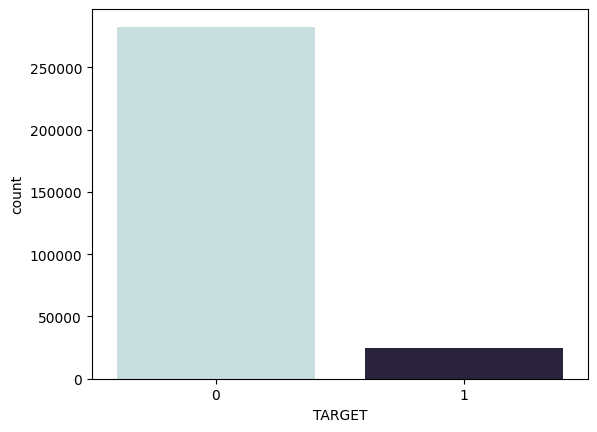

In [21]:
sns.countplot(data=X_train, x="TARGET", palette="ch:start=.2,rot=-.3")

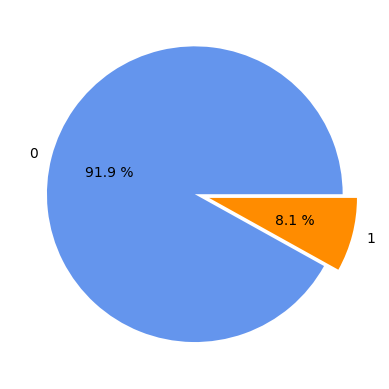

In [29]:
# https://python-charts.com/es/colores/

from matplotlib import cm
from matplotlib import colors

plt.pie([target_0,target_1], labels=[0,1], autopct="%0.1f %%", explode=(0,0.1), colors= ("#6495ED","#FF8C00"))
plt.show()

In [34]:
# 5. Show the number of columns of each data type.

X_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [36]:
# 6. For categorical variables, show the number of distinct values in each column (number of labels)

X_train.select_dtypes(include=object).nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [41]:
# 7. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending
# (show only the 20 columns with higher missing pct)

missing_data = X_train.isna() # true or false
missing_data = missing_data.sum()/len(X_train) # percentage
missing_data = (missing_data.sort_values(ascending=False)[0:20]).map(lambda x:format(x,'.2%')) # ordered by percentage
missing_data

COMMONAREA_MEDI             69.87%
COMMONAREA_AVG              69.87%
COMMONAREA_MODE             69.87%
NONLIVINGAPARTMENTS_MODE    69.43%
NONLIVINGAPARTMENTS_AVG     69.43%
NONLIVINGAPARTMENTS_MEDI    69.43%
FONDKAPREMONT_MODE          68.39%
LIVINGAPARTMENTS_MODE       68.35%
LIVINGAPARTMENTS_AVG        68.35%
LIVINGAPARTMENTS_MEDI       68.35%
FLOORSMIN_AVG               67.85%
FLOORSMIN_MODE              67.85%
FLOORSMIN_MEDI              67.85%
YEARS_BUILD_MEDI            66.50%
YEARS_BUILD_MODE            66.50%
YEARS_BUILD_AVG             66.50%
OWN_CAR_AGE                 65.99%
LANDAREA_MEDI               59.38%
LANDAREA_MODE               59.38%
LANDAREA_AVG                59.38%
dtype: object

⬇︎**Analyzing distribution of variables**⬇︎